In [1]:
import copy
from collections import defaultdict
import gym

import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (8, 8)

N_EPISODES = 1000
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed = SEED
np.random.seed = SEED
torch.random.seed = SEED

# Game

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = "".join(["%s" % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print("----"*(self.n_cols)+"-")
            out = "| "
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = "x"
                if self.board[i, j] == -1:
                    token = "o"
                if self.board[i, j] == 0:
                    token = " "
                out += token + " | "
            print(out)
        print("----"*(self.n_cols)+"-")

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

def plot_board(env, pi, showtext=True, verbose=True):
    """Рисуем доску с оценками из стратегии pi"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap("Accent", 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=20, horizontalalignment="center", verticalalignment="center", color="w" )
            else:
                ax.text( a[1] , a[0] , "???", fontsize=20, horizontalalignment="center", verticalalignment="center", color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=60, horizontalalignment="center", verticalalignment="center", color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=60, horizontalalignment="center", verticalalignment="center", color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


def get_and_print_move(env, pi, s, actions, random=False, verbose=True):
    """Делаем ход, рисуем доску"""
    # plot_board(env, pi)
    if random:
        return np.random.randint(len(actions))
    else:
        if verbose:
            if pi is not None and s in pi.Q:
                for i,a in enumerate(actions):
                    print(i, a, pi.Q[s][i])
            else:
                print("Стратегия не знает, что делать...")
        return pi.getActionGreedy(s, len(actions))


def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True):
    """Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры"""
    done = False
    env.reset()
    while not done:
        print("\n")
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose)
        observation, reward, done, info = env.step(actions[a])

        if verbose:
            env.printBoard()
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False)


def get_empty_cells(state):
    """
    1 - empty cell
    0 - 0 cell
    2 - x cell
    """
    return [i for i, s in enumerate(state) if s == "1"]


def get_used_cells(state):
    return [i for i, s in enumerate(state) if s != "1"]


def print_episides_stats(policy_name, crosses_win, naughts_win, draws):
    print(f"{policy_name} policy stats")
    print("Crosses wins rate:", crosses_win / N_EPISODES)
    print("Naughts wins rate:", naughts_win / N_EPISODES)
    print("Draws rate:", draws / N_EPISODES )

### Demo



-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------


-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
|   | o |   | 
-------------


-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
| x | o |   | 
-------------


-------------
| o |   |   | 
-------------
|   |   | x | 
-------------
| x | o |   | 
-------------


-------------
| o |   |   | 
-------------
|   |   | x | 
-------------
| x | o | x | 
-------------


-------------
| o | o |   | 
-------------
|   |   | x | 
-------------
| x | o | x | 
-------------


-------------
| o | o | x | 
-------------
|   |   | x | 
-------------
| x | o | x | 
-------------
Крестики выиграли!


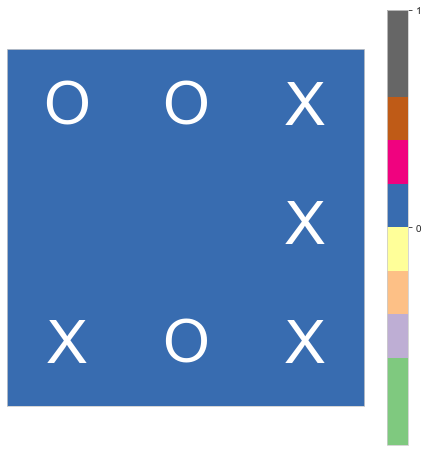

In [3]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True)

# Random strategy

In [4]:
class RandomAgent:
    def get_action(self, state):
        return random.choice(get_empty_cells(state))

In [5]:
def run_eposide(env, agent1=RandomAgent(), agent2=RandomAgent(), verbose=False):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    state, empty_cells, turn = env.getState()
    while not done:
        if turn == 1:
            action = agent1.get_action(state)
        else:
            action = agent2.get_action(state)
        (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        if verbose:
            env.printBoard()
            print(turn, reward)
    return reward

In [6]:
crosses_win, naughts_win, draws = 0, 0, 0
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

for _ in tqdm(range(N_EPISODES)):
    reward = run_eposide(env)
    if reward == 1:
        crosses_win += 1
    elif reward == -1:
        naughts_win += 1
    else:
        draws += 1
print_episides_stats("random", crosses_win, naughts_win, draws)

100%|██████████| 1000/1000 [00:00<00:00, 6096.08it/s]

random policy stats
Crosses wins rate: 0.575
Naughts wins rate: 0.279
Draws rate: 0.146


# Q-learning

In [7]:
class TabularQLearningAgent:
    def __init__(self, num_actions, lr, gamma, eps, side):
        self.cur_action, self.cur_state = None, None
        self.Q = defaultdict(lambda: np.zeros(num_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.side = side
        
    def get_action(self, state):
        self.Q[state][get_used_cells(state)] = -np.inf
        return np.argmax(self.Q[state])

    def get_eps_greedy_action(self, state):
        if np.random.rand() < self.eps:
            return random.choice(get_empty_cells(state))
        return self.get_action(state)
    
    def update_Q(self, next_state, next_action, reward):
        if self.cur_action:
            self.Q[self.cur_state][self.cur_action] += (
                self.lr * 
                (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[self.cur_state][self.cur_action])
            )
        self.cur_state = next_state
        self.cur_action = next_action

In [8]:
def train_TQL(env, crosses_agent, naughts_agent, n_episodes):
    """
    env - game env
    crosses_agent - crosses agent (X)
    naughts_agent - naughts agent (0)
    n_episodes - number of train iterations
    """
    turn2agent = {
        1: crosses_agent, 
        -1: naughts_agent
    }
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        turn2agent[1].curr_action, turn2agent[-1].curr_action = None, None
        done = False
        while not done:
            action = turn2agent[turn].get_eps_greedy_action(state)
            turn2agent[turn].update_Q(state, action, 0)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        turn2agent[1].update_Q(state, action, reward)
        turn2agent[-1].update_Q(state, action, reward)

    return turn2agent[1], turn2agent[-1]


def validate_TQL(env, agent, n_episodes):
    if agent.side == '0':
        turn2agent = { 
            1: RandomAgent(), 
            -1: agent
        }
    else:
        turn2agent = {
            1: agent, 
            -1: RandomAgent()
        }

    all_rewards = []
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        while not done:
            action = turn2agent[turn].get_action(state)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        all_rewards.append(reward)
    
    return all_rewards

### 3x3

100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


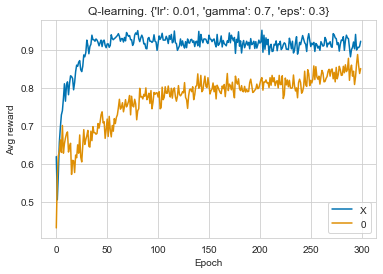

In [30]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()

hyperparams = dict(
    lr=1e-2,
    gamma=0.7,
    eps=0.3
)
crosses_agent = TabularQLearningAgent(len(state), side="X", **hyperparams)
naughts_agent = TabularQLearningAgent(len(state), side="0", **hyperparams)

N_EPOCHS = 300
N_ITER = 1000
crosses_rewards, naughts_rewards = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_TQL(env, crosses_agent, naughts_agent, N_ITER)
    crosses_rewards.append(np.mean(validate_TQL(env, crosses_agent, N_ITER)))
    naughts_rewards.append(np.mean(validate_TQL(env, naughts_agent, N_ITER)))

plt.plot(crosses_rewards, label="X")
plt.plot(naughts_rewards, label="0")
plt.title(f"Q-learning. {hyperparams}")
plt.xlabel("Epoch")
plt.ylabel("Avg reward")
plt.legend()
plt.show()

### 4x4

100%|██████████| 500/500 [09:33<00:00,  1.15s/it]


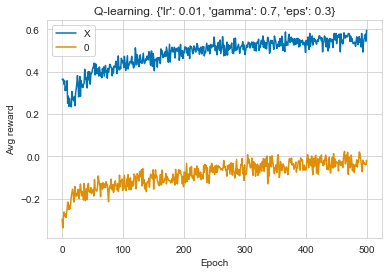

In [31]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
state, _, _ = env.getState()

hyperparams = dict(
    lr=1e-2,
    gamma=0.7,
    eps=0.3
)
crosses_agent = TabularQLearningAgent(len(state), side="X", **hyperparams)
naughts_agent = TabularQLearningAgent(len(state), side="0", **hyperparams)

N_EPOCHS = 500
N_ITER = 1000
crosses_rewards, naughts_rewards = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_TQL(env, crosses_agent, naughts_agent, N_ITER)
    crosses_rewards.append(np.mean(validate_TQL(env, crosses_agent, N_ITER)))
    naughts_rewards.append(np.mean(validate_TQL(env, naughts_agent, N_ITER)))

plt.plot(crosses_rewards, label="X")
plt.plot(naughts_rewards, label="0")
plt.title(f"Q-learning. {hyperparams}")
plt.xlabel("Epoch")
plt.ylabel("Avg reward")
plt.legend()
plt.show()

# Deep Q-network

## DQN & DuelingDQNet

In [25]:
class DeepQNetwork(torch.nn.Module):
    "Classic DQN"
    def __init__(self, hid_dim, game_size, n_actions):
        super().__init__()
        self.hid_dim = hid_dim
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=hid_dim, kernel_size=game_size)
        self.activation = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(hid_dim, hid_dim)
        self.fc2 = torch.nn.Linear(hid_dim, n_actions)
        
    def forward(self, state):
        x = self.conv(state).view(-1, self.hid_dim).requires_grad_(True)
        x = self.fc1(x).requires_grad_(True)
        x = self.activation(x).requires_grad_(True)
        return self.fc2(x).requires_grad_(True)


class DuelingDQNet(torch.nn.Module):
    "Duieling DQN architecture"
    def __init__(self, hid_dim, game_size, n_actions):
        super().__init__()
        self.hid_dim = hid_dim
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=hid_dim, kernel_size=game_size)
        self.activation = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(hid_dim, hid_dim)
        self.fc_adv = torch.nn.Linear(hid_dim, n_actions)
        self.fc_val = torch.nn.Linear(hid_dim, 1)
        
    def forward(self, state):
        x = self.conv(state).view(-1, self.hid_dim)
        x = self.fc1(x)
        x = self.activation(x)
        adv = self.fc_adv(x)
        val = self.fc_val(x)
        return val + (adv - adv.mean())


Experience = namedtuple(
    'Experience', field_names=['state', 'action', 'next_state', 'reward']
)
class ExperienceBuffer:
    "Buffer for DeepQNetwork"
    def __init__(self, capacity):
        self.capacity = capacity
        self._buffer = []
        self.position = 0
        self.device = "cpu"

    def add(self, state, action, next_state, reward):
        if len(self._buffer) < self.capacity:
            self._buffer.append(None)
            
        self._buffer[self.position] = [
            state, 
            action, 
            next_state, 
            reward
        ]
        # self._buffer[self.position] = Experience(state, action, next_state, reward)

        self.position = (self.position + 1) % self.capacity
       
    def get_batch(self, batch_size):
        buff_sample = random.sample(self._buffer, batch_size)

        # states = torch.from_numpy(np.vstack([t.state for t in buff_sample if t is not None])).float().to(self.device)
        # actions = torch.from_numpy(np.vstack([t.action for t in buff_sample if t is not None])).long().to(self.device)
        # rewards = torch.from_numpy(np.vstack([t.reward for t in buff_sample if t is not None])).float().to(self.device)
        # next_states = torch.from_numpy(np.vstack([t.next_state for t in buff_sample if t is not None])).float().to(self.device)
        # return states, actions, next_states, rewards

        states, actions, next_states, rewards = [], [], [], []
        for state, action, next_state, reward in buff_sample:
            states.append(state)
            actions.append(torch.tensor(action)[None])
            next_states.append(next_state)
            rewards.append(torch.tensor(reward)[None])
        return [torch.cat(states), torch.cat(actions).long().unsqueeze(0), torch.cat(next_states), torch.cat(rewards)]

    def __len__(self):
        return len(self._buffer)

## DQN Agent

In [26]:
class DQNAgent:
    "Deep Q-Net agent"
    def __init__(
        self, 
        model, 
        hid_dim, 
        game_size, 
        n_actions, 
        buffer_capacity, 
        batch_size,
        lr, 
        gamma, 
        eps, 
        update_every, 
        target_update_every, 
        side,
        device=DEVICE
    ):
        self.side = side  # X or 0
        self.device = device
        self.gamma = gamma
        self.eps = eps
        self.game_size = game_size
        self.exp_buffer = ExperienceBuffer(buffer_capacity)
        self.update_every = update_every
        self.target_update_every = target_update_every
        self.cur_step = 0
        self.batch_size = batch_size

        self.qnet_local = model(hid_dim, game_size, n_actions).to(self.device)
        self.qnet_target = model(hid_dim, game_size, n_actions).to(self.device)
        self.qnet_local.train()
        self.optimizer = torch.optim.Adam(self.qnet_local.parameters(), lr=lr)
        self.criterion = torch.nn.MSELoss()

        self.curr_action, self.curr_state = None, None
        
    @staticmethod
    def get_2d_state(state, size):
        # return np.array(list(state)).astype(float).reshape(size, size) 
        return torch.tensor(list(map(float, list(state)))).reshape(1, 1, size, size)
    
    def update_buffer(self, next_state, next_action, reward):
        if self.curr_action:
            self.exp_buffer.add(
                self.get_2d_state(self.curr_state, self.game_size), 
                self.curr_action,
                self.get_2d_state(next_state, self.game_size),
                reward
            )
        self.curr_state, self.curr_action = next_state, next_action

    def _train_step(self):
        batch = self.exp_buffer.get_batch(self.batch_size)
        for i, sample in enumerate(batch):
            batch[i] = sample.to(self.device)

        states, actions, next_states, rewards = batch
        states = states.view(-1, 1, self.game_size, self.game_size)
        next_states = next_states.view(-1, 1, self.game_size, self.game_size)

        q_expected = self.qnet_local(states).gather(1, actions)
        q_targets_next = self.qnet_target(next_states).max(1)[0].unsqueeze(1)
        q_targets = self.gamma * q_targets_next + rewards
        
        self.optimizer.zero_grad()
        loss = self.criterion(q_expected, q_targets)
        loss.backward()
        self.optimizer.step()        

    def train_step(self, state, action, reward):
        self.update_buffer(state, action, reward)
        self.cur_step += 1
        if (self.cur_step % self.update_every) == 0 and len(self.exp_buffer) > self.batch_size:
            self._train_step()
        if (self.cur_step % self.target_update_every) == 0:
            self.qnet_target.load_state_dict(copy.deepcopy(self.qnet_local.state_dict()))
    
    def get_action(self, state):
        
        state_tensor = self.get_2d_state(state, self.game_size).to(self.device)
        # state_tensor = torch.from_numpy(self.get_2d_state(state, self.game_size)).float().unsqueeze(0).to(self.device)

        actions = self.qnet_target(state_tensor).flatten()
        actions[get_used_cells(state)] = -np.inf 
        return actions.argmax().item()
    
    def get_eps_greedy_action(self, state):
        if np.random.rand() < self.eps:
            return random.choice(get_empty_cells(state))
        return self.get_action(state)


In [27]:
def train_DQN(env, crosses_agent, naughts_agent, n_episodes):
    turn2agent = {
        1: crosses_agent, 
        -1: naughts_agent
    }

    for _ in range(n_episodes):
        env.reset()        
        state, empty_cells, turn = env.getState()
        turn2agent[1].curr_action, turn2agent[-1].curr_action = None, None
        done = False
        
        while not done:
            action = turn2agent[turn].get_eps_greedy_action(state)
            turn2agent[turn].update_buffer(state, action, 0)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
            
        turn2agent[1].train_step(state, action, reward)
        turn2agent[-1].train_step(state, action, reward)


def validate_DQN(env, agent, n_episodes):
    if agent.side == 'o':
        turn2agent = { 
            1: RandomAgent(), 
            -1: agent
        }
    else:
        turn2agent = {
            1: agent, 
            -1: RandomAgent()
        }

    all_rewards = []
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        while not done:
            with torch.no_grad():
                action = turn2agent[turn].get_action(state)
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        all_rewards.append(reward)
    
    return all_rewards


### 3x3 DQN

In [29]:
BATCH_SIZE = 256
HID_DIM = 128
GAME_SIZE = 3  # kernel size
BUFFER_SIZE = 10**3
LR = 1e-6
GAMMA = 0.7
EPS = 0.2
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 2000
N_EPOCHS = 100
N_EPISODES = 1000

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()
    
crosses_agent = DQNAgent(
    DeepQNetwork, HID_DIM, GAME_SIZE, len(state), BUFFER_SIZE, BATCH_SIZE, LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'X'
)
naughts_agent = DQNAgent(
    DeepQNetwork, HID_DIM, GAME_SIZE, len(state), BUFFER_SIZE, BATCH_SIZE, LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, '0'
)

crosses_rewards, naughts_rewards = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_DQN(env, crosses_agent, naughts_agent, N_EPISODES)
    crosses_rewards.append(np.mean(validate_DQN(env, crosses_agent, N_EPISODES)))
    naughts_rewards.append(np.mean(validate_DQN(env, naughts_agent, N_EPISODES)))

plt.plot(crosses_rewards, label='X')
plt.plot(naughts_rewards, label='O')
plt.title(f'DQN lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/and/miniforge3/envs/made/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 56%|█████▌    | 56/100 [03:31<02:39,  3.63s/it]

### 3x3 DuelingDQN

100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


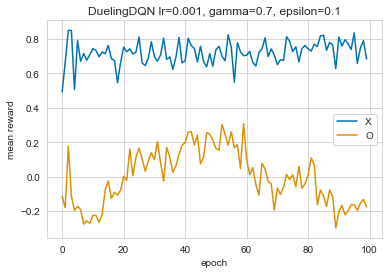

In [18]:
BATCH_SIZE = 2
HID_DIM = 128
GAME_SIZE = 3  # kernel size
BUFFER_SIZE = 10**3
LR = 1e-3
GAMMA = 0.7
EPS = 0.1
UPDATE_EVERY = 4
UPDATE_TARGET_EVERY = 500
N_EPOCHS = 100
N_EPISODES = 1000

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
state, _, _ = env.getState()
    
crosses_agent = DQNAgent(
    DuelingDQNet, HID_DIM, GAME_SIZE, len(state), BUFFER_SIZE, BATCH_SIZE, LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, 'X'
)
naughts_agent = DQNAgent(
    DuelingDQNet, HID_DIM, GAME_SIZE, len(state), BUFFER_SIZE, BATCH_SIZE, LR, GAMMA, EPS, UPDATE_EVERY, UPDATE_TARGET_EVERY, '0'
)

crosses_rewards, naughts_rewards = [], []

for _ in tqdm(range(N_EPOCHS)):
    train_DQN(env, crosses_agent, naughts_agent, N_EPISODES)
    crosses_rewards.append(np.mean(validate_DQN(env, crosses_agent, N_EPISODES)))
    naughts_rewards.append(np.mean(validate_DQN(env, naughts_agent, N_EPISODES)))

plt.plot(crosses_rewards, label='X')
plt.plot(naughts_rewards, label='O')
plt.title(f'DuelingDQN lr={LR}, gamma={GAMMA}, epsilon={EPS}')
plt.xlabel('epoch')
plt.ylabel('mean reward')
plt.legend()
plt.show()